## Week 4, Lab 2: Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: It's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious  scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

---

## Step 2: Obtain the data.

### 1. Read in the data.

In [1]:
# Imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# # Imports statistics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,\
accuracy_score, plot_roc_curve, roc_auc_score, recall_score, \
precision_score, f1_score, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Open dataset
df = pd.read_csv("./chronic_kidney_disease_full.csv")

In [3]:
# View
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [4]:
# Create a dictionary to rename columns
col_name_dict = {'age':'age',
                'bp':'blood_pressure',
                'sg':'specific_gravity',
                'al':'albumin',
                'su':'sugar',
                'rbc':'red_blood_cells',
                'pc':'pus_cell',
                'pcc':'pus_cell_clumps',
                'ba':'bacteria',
                'bgr':'blood_glucose_random',
                'bu':'blood_urea',
                'sc':'serum_creatinine',
                'sod':'sodium',
                'pot':'potassium',
                'hemo':'hemoglobin',
                'pcv':'packed_cell_volume',
                'wbcc':'white_blood_cell_count',
                'rbcc':'red_blood_cell_count',
                'htn':'hypertension',
                'dm':'diabetes_mellitus',
                'cad':'coronary_artery_disease',
                'appet':'appetite',
                'pe':'pedal_edema',
                'ane': 'anemia',
                'class': 'ckd'}

In [5]:
# Rename columns for easy to understand
df = df.rename(columns=col_name_dict)

### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

In [6]:
# Check the ckd variable to see if unbalanced classes
# Probably can split (majority class 62.5)
df['ckd'].value_counts(normalize=True)*100

ckd       62.5
notckd    37.5
Name: ckd, dtype: float64

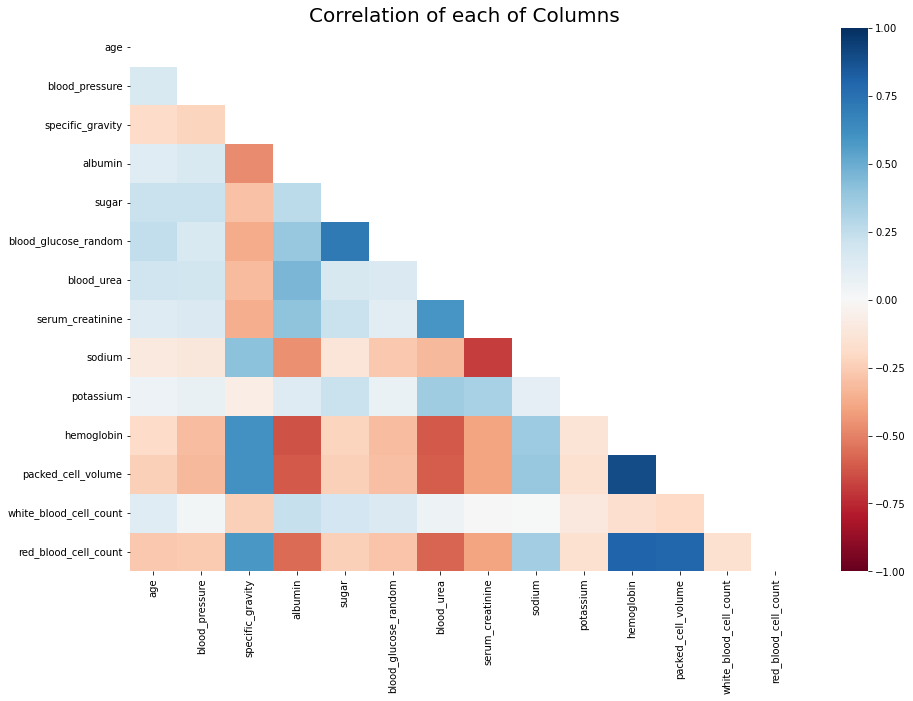

In [7]:
# Compare each variable to see which variables appear relationships
# Creating heatmap
# Highest correlation between hemoglobin and packed_cell_volume
# High correlation in blood and sugar groups
# (red_blood_cells, hemoglobin and packed_cell_volume)
# (blood_glucose_random and sugar)
plt.figure(figsize=(15,10))
corr = df.corr()
matrix = np.triu(corr)
sns.heatmap(corr, annot = False, cmap = 'RdBu',
            mask=matrix, vmin=-1, vmax=1)
plt.title(label='Correlation of each of Columns', fontsize=20);

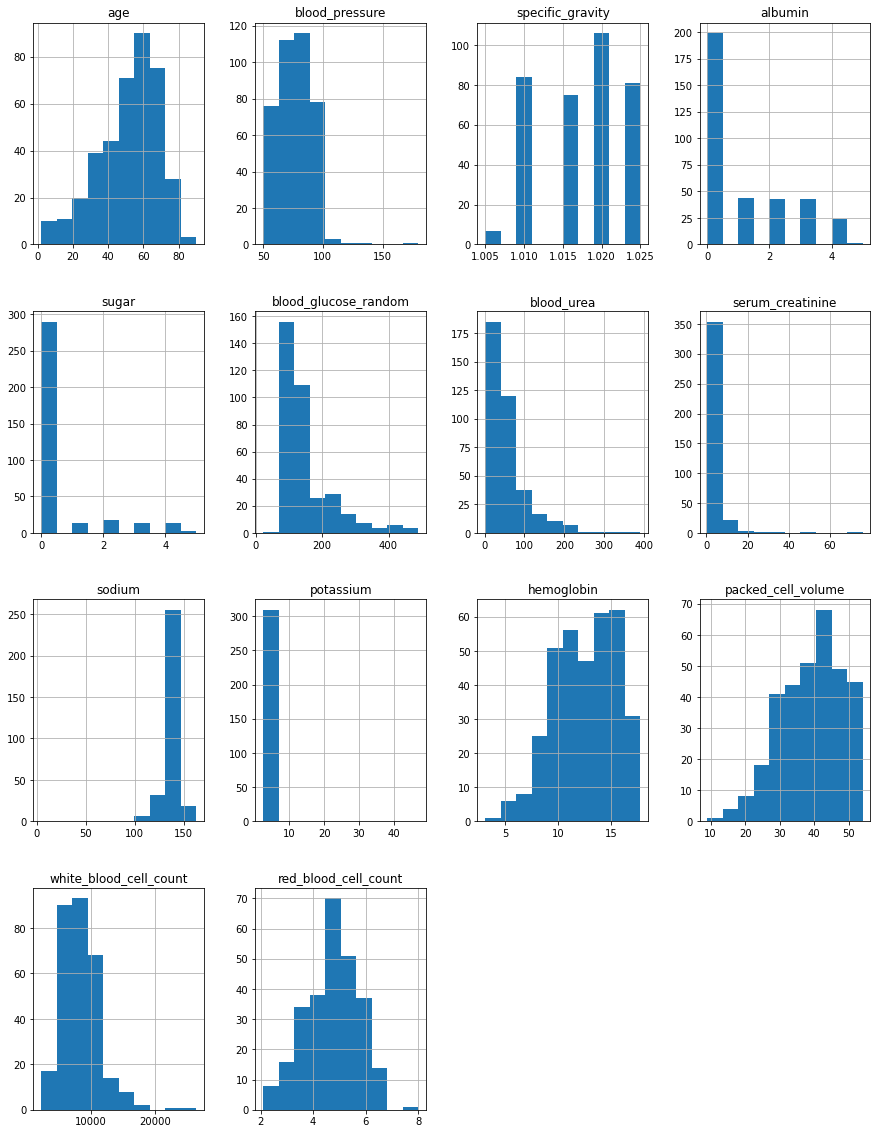

In [8]:
# Check out the distributions of each variable
# Creating hitogram 
# "potassium" might have only 0 
df.hist(figsize=(15,20));

In [9]:
# Check column potassium
# Not have only value
df["potassium"].value_counts()

3.5     30
5.0     30
4.9     27
4.7     17
4.8     16
3.9     14
3.8     14
4.1     14
4.2     14
4.0     14
4.4     14
4.5     13
4.3     12
3.7     12
3.6      8
4.6      7
3.4      5
5.2      5
5.3      4
5.7      4
3.2      3
5.5      3
6.3      3
5.4      3
2.9      3
3.3      3
5.6      2
3.0      2
6.5      2
2.5      2
5.9      2
5.8      2
7.6      1
47.0     1
6.6      1
5.1      1
6.4      1
2.8      1
2.7      1
39.0     1
Name: potassium, dtype: int64

Answer:
- Form heatmap chart we can see a correlation with these features such as:
    - Hemoglobin and packed_cell_volume may be more relationship among these features
    - Red_blood_cells, hemoglobin and packed_cell_volume may be some relationship among these features
    - Blood_glucose_random and sugar)may be some relationship among these features
    
There might be some relationship among these features but I'm not a doctor who is understood to select features as related to chronic kidney disease (CKD) therefore I'll want to include interaction terms.

- From histogram chart we can see a potassium column that overwhelmingly afterward we check that is not overwhelmingly but it have more low values. We decide to take on a feature for prediction

---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

In [10]:
# Check missing values
(df.isnull().mean()*100).sort_values(ascending=False)

red_blood_cells            38.00
red_blood_cell_count       32.75
white_blood_cell_count     26.50
potassium                  22.00
sodium                     21.75
packed_cell_volume         17.75
pus_cell                   16.25
hemoglobin                 13.00
sugar                      12.25
specific_gravity           11.75
albumin                    11.50
blood_glucose_random       11.00
blood_urea                  4.75
serum_creatinine            4.25
blood_pressure              3.00
age                         2.25
bacteria                    1.00
pus_cell_clumps             1.00
hypertension                0.50
diabetes_mellitus           0.50
coronary_artery_disease     0.50
appetite                    0.25
pedal_edema                 0.25
anemia                      0.25
ckd                         0.00
dtype: float64

Answer: Some of the data is missing from every columns except for class(ckd). 
In red_blood_cells, red_blood_cell_count, and white_blood_cell_count columns are missing over 38-26% of their data.

### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

In [11]:
# Check row
df.shape

(400, 25)

In [12]:
# Drop row have missing values
df.dropna(inplace = False).shape

(158, 25)

Answer: Remaining rows are 158 in our dataframe
- Many of these 242(400-158) rows do have information stored for some of the cells. I'm discarding a lot of data if we drop any observation that has at least one missing value!
- We have a much smaller dataset to train and test our model on which will make our model less accurate to future data.

Thus I will keep all of my data.

#### Data cleaning: Missing values

##### Numerical Columns 

In [13]:
# Create list of numerical columns
num_columns = df.select_dtypes(exclude=object).columns
num_columns

Index(['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar',
       'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
       'potassium', 'hemoglobin', 'packed_cell_volume',
       'white_blood_cell_count', 'red_blood_cell_count'],
      dtype='object')

In [14]:
# Check some statistics
df.describe()

,age,blood_pressure,specific_gravity,albumin,sugar,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,hemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


In [15]:
# I decide to impute the median in the missing value of numerical columns
# Because of average of people
for i in num_columns:
    df[i].fillna(df[i].median(), inplace=True)

In [16]:
# Recheck missing values
df[num_columns].isnull().sum()

age                       0
blood_pressure            0
specific_gravity          0
albumin                   0
sugar                     0
blood_glucose_random      0
blood_urea                0
serum_creatinine          0
sodium                    0
potassium                 0
hemoglobin                0
packed_cell_volume        0
white_blood_cell_count    0
red_blood_cell_count      0
dtype: int64

##### Categorical columns

In [17]:
# Create list of categorical columns
cat_columns = df.select_dtypes(include=object).columns
cat_columns

Index(['red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria',
       'hypertension', 'diabetes_mellitus', 'coronary_artery_disease',
       'appetite', 'pedal_edema', 'anemia', 'ckd'],
      dtype='object')

In [18]:
# Infer all of missing values in category columns is the normal value
# I decide to impute 0 
for i in cat_columns:
    df[i].fillna(0, inplace=True)

In [19]:
# Recheck missing values
df[cat_columns].isnull().sum()

red_blood_cells            0
pus_cell                   0
pus_cell_clumps            0
bacteria                   0
hypertension               0
diabetes_mellitus          0
coronary_artery_disease    0
appetite                   0
pedal_edema                0
anemia                     0
ckd                        0
dtype: int64

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

Answer: 
-  User errors such as entering the data wrong into the system because record by hand or staff who are tired from work
-  Different doctor check up of symptoms(different interpretation)
-  Maybe lab results were mixed up 
-  Maybe machines aren't properly calibrated so our measurements are incorrect

---

## Step 4: Model the data.

### 6. Suppose that I want to construct a model where no person who has chronic kidney disease (CKD) will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.

Answer: The model would be to tell all people that they have CKD so that everyone would ever be told they do not have CKD. (Type I error)

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer:  In this problem, assuming that CKD is the "positive" class, we minimized false negatives. This is equivalent to maximizing sensitivity.

### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

Answer: This model it will be unethical because people will treat expensive symptoms, lost opportunity and have a lots of anxiety then people would stop trusting your test.

### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

Answer: The model would be to tell no people that they have CKD so that everyone would ever be told they do have CKD. (Type II error)

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: In this problem, assuming that CKD is the "positive" class, we minimized false positives. This is equivalent to maximizing specificity.
-  Sensitivity would be what we optimize for. Yes we did since sensitivity is True positives / true positives + false negatives.

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

Answer: This model it will be unethical because disadvantage would be that we are not telling them that they have CKD when they actually do have it so that they are not having treatment for CKD. This would likely result in deaths of patients. Furthermore,
people would stop trusting your test.

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint: Remember to do a train/test split!

In [20]:
# Check values in each categorical columns for decide to impute
for i in cat_columns:
    print("--------------------")
    print(df[i].value_counts())

--------------------
normal      201
0           152
abnormal     47
Name: red_blood_cells, dtype: int64
--------------------
normal      259
abnormal     76
0            65
Name: pus_cell, dtype: int64
--------------------
notpresent    354
present        42
0               4
Name: pus_cell_clumps, dtype: int64
--------------------
notpresent    374
present        22
0               4
Name: bacteria, dtype: int64
--------------------
no     251
yes    147
0        2
Name: hypertension, dtype: int64
--------------------
no     261
yes    137
0        2
Name: diabetes_mellitus, dtype: int64
--------------------
no     364
yes     34
0        2
Name: coronary_artery_disease, dtype: int64
--------------------
good    317
poor     82
0         1
Name: appetite, dtype: int64
--------------------
no     323
yes     76
0        1
Name: pedal_edema, dtype: int64
--------------------
no     339
yes     60
0        1
Name: anemia, dtype: int64
--------------------
ckd       250
notckd    150
Nam

In [21]:
# Create dict to change values in c
dict_binary = {"normal":0, "abnormal":1,
              "notpresent":0,"present":1,
              'no':0, 'yes':1,
              "good":0, "poor":1,
              "ckd":1, "notckd":0, 0:0}

In [22]:
# Change values in cat_columns to binary value
# normal value is 0
# abnormal value is 1 
for i in cat_columns:
    df[i] = df[i].map(dict_binary)

In [23]:
# Recheck
df.head()

,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,pedal_edema,anemia,ckd
0,48.0,80.0,1.020,1.0,0.0,0,0,0,0,121.0,...,44.0,7800.0,5.2,1,1,0,0,0,0,1
1,7.0,50.0,1.020,4.0,0.0,0,0,0,0,121.0,...,38.0,6000.0,4.8,0,0,0,0,0,0,1
2,62.0,80.0,1.010,2.0,3.0,0,0,0,0,423.0,...,31.0,7500.0,4.8,0,1,0,1,0,1,1
3,48.0,70.0,1.005,4.0,0.0,0,1,1,0,117.0,...,32.0,6700.0,3.9,1,0,0,1,1,1,1
4,51.0,80.0,1.010,2.0,0.0,0,0,0,0,106.0,...,35.0,7300.0,4.6,0,0,0,0,0,0,1


In [24]:
# Define X & y
X = df.drop(columns="ckd")
y = df["ckd"]

In [25]:
# Split into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42)

In [26]:
# Instantiate our model
logreg = LogisticRegression(penalty='none')

# Fit our model.
logreg.fit(X_train, y_train)

LogisticRegression(penalty='none')

---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

In [27]:
# training accuracy
print(f" Training accuracy : {logreg.score(X_train, y_train)}")
# testing accuracy
print(f" Testing accuracy : {logreg.score(X_test, y_test)}")

# Appears no overfitting (variance) as training anw testing

 Training accuracy : 0.9233333333333333
 Testing accuracy : 0.92


In [28]:
# Interpret the coefficient
list(zip(np.exp(logreg.coef_[0]),X))

[(0.996258086110114, 'age'),
 (1.069398576272617, 'blood_pressure'),
 (1.0025334490469178, 'specific_gravity'),
 (1.1273993449502588, 'albumin'),
 (1.012194381784698, 'sugar'),
 (1.0123375349364758, 'red_blood_cells'),
 (1.0158667347484864, 'pus_cell'),
 (1.0077985629670527, 'pus_cell_clumps'),
 (1.0027383499541087, 'bacteria'),
 (1.0593135965525027, 'blood_glucose_random'),
 (1.0348258931041767, 'blood_urea'),
 (1.105473907670356, 'serum_creatinine'),
 (1.0582833877819804, 'sodium'),
 (1.0013004092461197, 'potassium'),
 (0.8019546652598913, 'hemoglobin'),
 (0.647990539434842, 'packed_cell_volume'),
 (1.0000539614083115, 'white_blood_cell_count'),
 (0.9534442000828116, 'red_blood_cell_count'),
 (1.0341262407979313, 'hypertension'),
 (1.027121637665531, 'diabetes_mellitus'),
 (1.0079744749552928, 'coronary_artery_disease'),
 (1.0213407231830531, 'appetite'),
 (1.0276386884915154, 'pedal_edema'),
 (1.0111549717207033, 'anemia')]

In [29]:
# Quantitative features
num_columns

Index(['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar',
       'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
       'potassium', 'hemoglobin', 'packed_cell_volume',
       'white_blood_cell_count', 'red_blood_cell_count'],
      dtype='object')

In [30]:
# Categorical/dummy features
cat_columns

Index(['red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria',
       'hypertension', 'diabetes_mellitus', 'coronary_artery_disease',
       'appetite', 'pedal_edema', 'anemia', 'ckd'],
      dtype='object')

Answer: 
- Example highest coefficient in quantitative features
 - As albumin increases by 1 unit,
 - Someone is about 1.13 times as likely to be have probability CKD 
- Example highest coefficient in categorical features
 - As serum_creatinine increases by 1 unit,
 - Someone is about 1.11 times as likely to be have probability CKD 

### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

Answer: 
- Logistic regression is to find the best-fitting model to describe the relationship between a binary outcome and a set of independent variables.
- Generates the coefficients so that we can understand how X affects y(logit transformation of the probability that the characteristic of interest), as we saw above.

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [31]:
# Predict
y_preds = logreg.predict(X_test) 

In [32]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_preds)
cm

array([[31,  4],
       [ 4, 61]], dtype=int64)

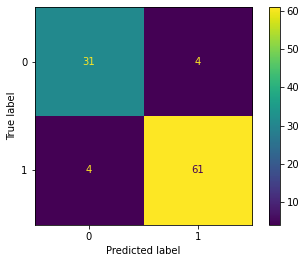

In [33]:
# Display confusion matrix
ConfusionMatrixDisplay(confusion_matrix=cm, 
                       display_labels=logreg.classes_).plot();

Answer: It makes more sense to generate a confusion matrix on our test data, as that provides a proper evaluation of our methods.
- True Positive : 61 people
- True Negative : 31 people
- False Positive : 4 people
- False Negative : 4 people

### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

Answer: 
- Just go with optimizing sensitivity means minimize false negatives.(I'd rather tell people they have CKD and be wrong than tell people they're healthy and have them get sick.
- I might try to optimize f1-score, a combination of sensitivity and specificity.

### 18 (BONUS). Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

In [34]:
roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])

0.9793406593406594

In [35]:
accuracy_score(y_test, y_preds)

0.92

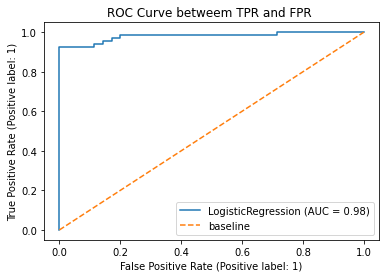

In [36]:
# Used library sklearn.metrics import plot_roc_curve instead of write function
plot_roc_curve(logreg, X_test, y_test)
plt.plot([0,1], [0,1], label='baseline', linestyle='--')
plt.title("ROC Curve betweem TPR and FPR ")
plt.legend();

In [37]:
# Create function
def get_predictions(probabilities, threshold):
    return [0 if prob < threshold else 1 for prob in probabilities]

In [38]:
# Need to double check all the elements of this creation
# (Needed something to do after the deluge of rain with heavy winds ruined pool time)
threshold_dict = {'threshold':[], 'accuracy': [], 'true_negatives':[], 
                  'false_positives':[],'false_negatives':[],'true_positives':[], 
                  'tpr':[], 'fpr':[] }

threshold_list = [0.05, 0.10, 0.25, 0.30, 0.40, 0.50, 0.60, 0.75]
for threshold in threshold_list:
    preds = get_predictions(logreg.predict_proba(X_test)[:,1], 
                            threshold)
    threshold_dict['threshold'].append(threshold)
    threshold_dict['accuracy'].append(accuracy_score(y_test, preds))
    threshold_dict['true_negatives'].append(confusion_matrix(y_test, preds).ravel()[0])
    threshold_dict['false_positives'].append(confusion_matrix(y_test, preds).ravel()[1])
    threshold_dict['false_negatives'].append(confusion_matrix(y_test, preds).ravel()[2])
    threshold_dict['true_positives'].append(confusion_matrix(y_test, preds).ravel()[3])
    threshold_dict['tpr'].append(recall_score(y_test, preds))
    specificity = (confusion_matrix(y_test, preds).ravel()[0]) / \
    (confusion_matrix(y_test, preds).ravel()[0] + confusion_matrix(y_test, preds).ravel()[1])
    threshold_dict['fpr'].append(1 - specificity)

threshold_df = pd.DataFrame(threshold_dict)
threshold_df

,threshold,accuracy,true_negatives,false_positives,false_negatives,true_positives,tpr,fpr
0,0.05,0.80,16,19,1,64,0.984615,0.542857
1,0.10,0.84,20,15,1,64,0.984615,0.428571
2,0.25,0.91,27,8,1,64,0.984615,0.228571
3,0.30,0.91,27,8,1,64,0.984615,0.228571
4,0.40,0.91,29,6,3,62,0.953846,0.171429
5,0.50,0.92,31,4,4,61,0.938462,0.114286
6,0.60,0.92,32,3,5,60,0.923077,0.085714
7,0.75,0.95,35,0,5,60,0.923077,0.000000


In [39]:
preds_30 = get_predictions(logreg.predict_proba(X_test)[:,1], 0.3)

In [40]:
# Predict threshold 0.30
cm_30 = confusion_matrix(y_test, preds_30)

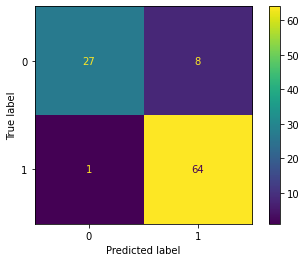

In [41]:
# Display confusion matrix threshold 0.30
ConfusionMatrixDisplay(confusion_matrix=cm_30, 
                       display_labels=logreg.classes_).plot();

# Used Threshold 0.3 in model 
# We reduce FN from 4 to 6 (Good)
# We increase TP from 60 to 4 (Good)
# True positive rate from 0.94 to 0.98 (Good)
# BUT We increase FP from 4 to 8 (So bad)

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

Answer: 
- Unbalanced classes are usually a problem. Suppose we have an imbalanced binary classification problem with an imbalance of only 1 has CKD to 100 (1:100) means that for every one example have CKD in one class, there are 100 examples in the other class so the model will predict most of the time that new people do not have CKD because we have very low of training data who have CKD.
- Yes we have unbalanced classes in the CKD analysis is a problem because our model will not be able to accurately classify someone with CKD.

### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

Answer: Let's talk Covid-19 and fever, a patient who are fever can happen frequently so you can easily treat a patient because you see it often and a lot of information symptoms. On the other hand, for Covid-19 which presents with odd symptoms that you've never seen before and less of information symptoms. You do research, but it's very hard to understand this symptoms because you just don't have enough information to identify causes or recommend treatments.

### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 200,000 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with around 200,000 observations, of which only about 0.00075% are non-CKD individuals.

In [42]:
# Generate a random sample of size 200,000 of individuals who have CKD
df_rdsp = df[df['ckd'] == 1].sample(200_000, replace = True, random_state = 42)
df_rdsp

,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,pedal_edema,anemia,ckd
102,17.0,60.0,1.010,0.0,0.0,0,0,0,0,92.0,...,52.0,7000.0,4.8,0,0,0,0,0,0,1
179,72.0,90.0,1.010,2.0,0.0,0,1,1,0,124.0,...,39.0,8000.0,4.8,0,0,0,0,0,0,1
92,71.0,70.0,1.010,3.0,0.0,0,1,1,1,219.0,...,33.0,5600.0,3.6,1,1,1,0,0,0,1
14,68.0,80.0,1.010,3.0,2.0,0,1,1,1,157.0,...,16.0,11000.0,2.6,1,1,1,1,1,0,1
106,50.0,90.0,1.020,0.0,0.0,0,0,0,0,89.0,...,17.0,6500.0,4.8,1,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,65.0,90.0,1.020,2.0,1.0,1,0,0,0,270.0,...,36.0,9800.0,4.9,1,1,0,1,0,1,1
6,68.0,70.0,1.010,0.0,0.0,0,0,0,0,100.0,...,36.0,8000.0,4.8,0,0,0,0,0,0,1
231,60.0,90.0,1.020,0.0,0.0,0,0,0,0,269.0,...,35.0,8000.0,4.8,1,1,1,0,1,0,1
90,63.0,100.0,1.010,2.0,2.0,0,0,0,1,280.0,...,40.0,9800.0,4.2,1,0,1,0,0,0,1


In [43]:
# Create a new dataframe with the original data plus this random sample of data
df_new = pd.concat([df, df_rdsp])
df_new

,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,pedal_edema,anemia,ckd
0,48.0,80.0,1.020,1.0,0.0,0,0,0,0,121.0,...,44.0,7800.0,5.2,1,1,0,0,0,0,1
1,7.0,50.0,1.020,4.0,0.0,0,0,0,0,121.0,...,38.0,6000.0,4.8,0,0,0,0,0,0,1
2,62.0,80.0,1.010,2.0,3.0,0,0,0,0,423.0,...,31.0,7500.0,4.8,0,1,0,1,0,1,1
3,48.0,70.0,1.005,4.0,0.0,0,1,1,0,117.0,...,32.0,6700.0,3.9,1,0,0,1,1,1,1
4,51.0,80.0,1.010,2.0,0.0,0,0,0,0,106.0,...,35.0,7300.0,4.6,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,65.0,90.0,1.020,2.0,1.0,1,0,0,0,270.0,...,36.0,9800.0,4.9,1,1,0,1,0,1,1
6,68.0,70.0,1.010,0.0,0.0,0,0,0,0,100.0,...,36.0,8000.0,4.8,0,0,0,0,0,0,1
231,60.0,90.0,1.020,0.0,0.0,0,0,0,0,269.0,...,35.0,8000.0,4.8,1,1,1,0,1,0,1
90,63.0,100.0,1.010,2.0,2.0,0,0,0,1,280.0,...,40.0,9800.0,4.2,1,0,1,0,0,0,1


In [44]:
# Check % classes 
df_new["ckd"].value_counts(normalize=True).mul(100)

1    99.92515
0     0.07485
Name: ckd, dtype: float64

### 22. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. How would you describe the impact of unbalanced classes on logistic regression as a classifier?
> Be sure to look at how well it performs on non-CKD data.

In [45]:
# Define X & y
X_new = df_new.drop(columns="ckd")
y_new = df_new["ckd"]

In [46]:
# Split into training & testing sets
X_train_n , X_test_n , y_train_n , y_test_n = train_test_split(X_new, y_new, 
                                                                random_state=42)

In [47]:
# Instantiate our model
logreg_new = LogisticRegression(penalty='none')

# Fit our model.
logreg_new.fit(X_train_n, y_train_n)

LogisticRegression(penalty='none')

In [48]:
# training accuracy
print(f" Training accuracy : {logreg_new.score(X_train_n, y_train_n)}")
# testing accuracy
print(f" Testing accuracy : {logreg_new.score(X_test_n, y_test_n)}")

# Appears no overfitting (variance) as training anw testing
# Improve accuracy model from 0.92 to 0.99

 Training accuracy : 0.9993745841650034
 Testing accuracy : 0.9990818363273453


In [49]:
# Model 1 
print(classification_report(y_test, logreg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        35
           1       0.94      0.94      0.94        65

    accuracy                           0.92       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.92      0.92      0.92       100



In [50]:
# Model 2 which have random sampling with replacement the majority class
print(classification_report(y_test_n, logreg_new.predict(X_test_n)))

              precision    recall  f1-score   support

           0       1.00      0.06      0.12        49
           1       1.00      1.00      1.00     50051

    accuracy                           1.00     50100
   macro avg       1.00      0.53      0.56     50100
weighted avg       1.00      1.00      1.00     50100



Answer: 
- Comparing my models based on sensitivity in classification report call "recall".
 - Yes the model 2(unbalanced data) performed like because it has 100% of recall of majority class so more than model 1(balanced data) has about 94% of recall of majority class. In this case, it seems as though unbalanced classes actually makes our model perform better.
 
- The problem with unbalanced classes have trouble learning the patterns in the minority. There usually isn't enough data to learn what causes the minority class.

---

## Step 6: Answer the problem.

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!